# 00. 🔍 Intenção de Pesquisa

## Responder às seguintes questões

1. Existe relação entre as informações demográficas do indivíduo e a sua renda?
2. Existe correlação entre essas informações demográficas? Se sim, quais?

Para tanto, pretende-se usar métodos estatísticos para analisar as distribuições e avaliar a correlação dentro das variáveis categóricas e dentro das numéricas

# 01. 📑 Importações

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

# 02. 📖 Lendo Dados

In [3]:
df = pd.read_csv('./data/income.csv')
df.sample()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
44312,33,Private,85355,HS-grad,9,Separated,Machine-op-inspct,Not-in-family,White,Male,0,0,30,United-States,<=50K


# 03. 🧮 Dividindo em Treino e Teste e Analisando

In [4]:
y_col = ['income']
X_col = [col for col in df.columns if col not in y_col]

X = df[X_col]
y = df[y_col]

In [5]:
y['income'].unique()

array(['<=50K', '>50K'], dtype=object)

In [6]:
# convertendo rótulos em binário

y['income'] = y['income'].apply(lambda x: 1 if x == '>50K' else 0)
y['income'].unique()

array([0, 1])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=777)

In [8]:
y_train['income'].info()

<class 'pandas.core.series.Series'>
Index: 39073 entries, 41273 to 25002
Series name: income
Non-Null Count  Dtype
--------------  -----
39073 non-null  int64
dtypes: int64(1)
memory usage: 610.5 KB


In [9]:
positive_rate = int(y_train['income'].value_counts()[1] / len(y_train) * 100)
                    
print(f"taxa de positivos: {positive_rate}%")

taxa de positivos: 23%


In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39073 entries, 41273 to 25002
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              39073 non-null  int64 
 1   workclass        39073 non-null  object
 2   fnlwgt           39073 non-null  int64 
 3   education        39073 non-null  object
 4   educational-num  39073 non-null  int64 
 5   marital-status   39073 non-null  object
 6   occupation       39073 non-null  object
 7   relationship     39073 non-null  object
 8   race             39073 non-null  object
 9   gender           39073 non-null  object
 10  capital-gain     39073 non-null  int64 
 11  capital-loss     39073 non-null  int64 
 12  hours-per-week   39073 non-null  int64 
 13  native-country   39073 non-null  object
dtypes: int64(6), object(8)
memory usage: 4.5+ MB


In [11]:
df['educational-num'] = df['educational-num'].astype('object') # correção de dtype

In [12]:
num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.select_dtypes(exclude='number').columns

## 03.a 0️⃣ Análise de Valores Zerados

1. Existem muitos dados zerados nas colunas capital-gain capital-loss
2. Esses valores são realmente 0 ou são valores faltantes que foram preenchidos dessa forma?

In [13]:
X_train[num_cols].describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,39073.000000,3.907300e+04,39073.000000,39073.000000,39073.000000,39073.000000
mean,38.672075,1.895782e+05,10.087426,1063.749546,86.807028,40.441046
std,13.684519,1.060363e+05,2.568818,7376.302322,401.820249,12.417632
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175280e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.779370e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376460e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


<Axes: >

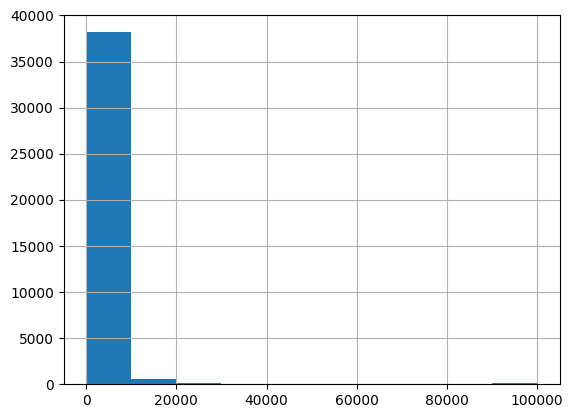

In [14]:
X_train['capital-gain'].hist()

<Axes: >

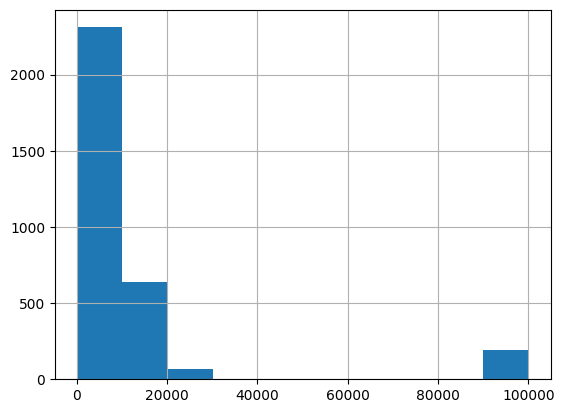

In [15]:
X_train[X_train['capital-gain'] != 0]['capital-gain'].hist()

<Axes: >

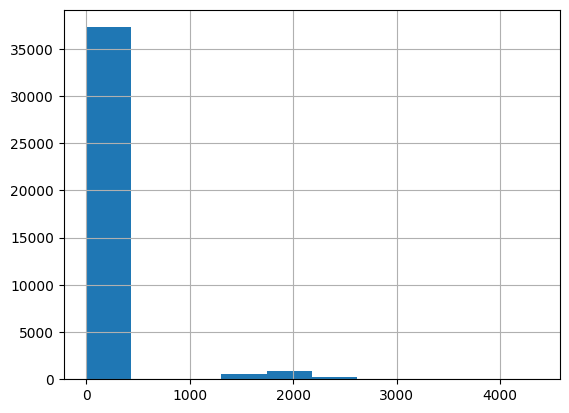

In [16]:
X_train['capital-loss'].hist()

<Axes: >

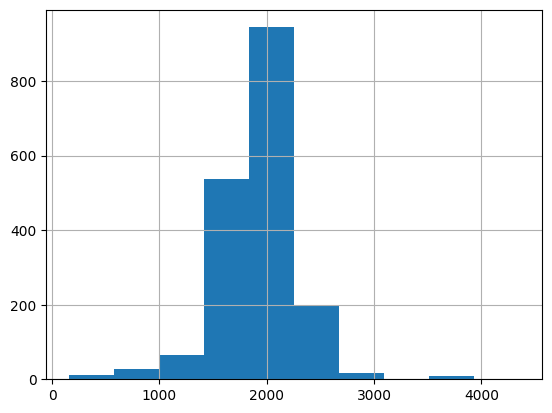

In [17]:
X_train[X_train['capital-loss'] != 0]['capital-loss'].hist()

In [18]:
print(len(X_train[X_train['capital-gain'] == 0]))
print(len(X_train[X_train['capital-gain'] != 0]))

X_train['no-capital-gain'] = X_train['capital-gain'].apply(lambda x: 1 if x == 0 else 0)

X_train['no-capital-gain'] = X_train['no-capital-gain'].astype('object')

35863
3210


In [19]:
print(len(X_train[X_train['capital-loss'] == 0]))
print(len(X_train[X_train['capital-loss'] != 0]))

X_train['no-capital-loss'] = X_train['capital-loss'].apply(lambda x: 1 if x == 0 else 0)

X_train['no-capital-loss'] = X_train['no-capital-loss'].astype('object')

37261
1812


In [20]:
cat_cols = X_train.select_dtypes(exclude='number').columns

### Teste Estatístico de Diferença Condicional

Como se tratam de colunas de ganho e perda de capital, vamos escolher colunas para comparar essas distribuições dentro dos dois grupos ("0" e "não 0"), para tanto, vamos escolher colunas que também possuem relação com poder financeiro.

As coluna escolhidas foram: workclass e occupation

O teste escolhido foi: o qui-2, pelo tamanho da amostra

alpha = 0.01

Ho: As variáveis são independentes

### Conclusão

Os zeros não são perdas aleatórias e que foram substituídas por 0. Pois os testes mostraram que há dependència entre eses valores e os das outras colunas

**workclass**

In [21]:
alpha = .01

tab = pd.crosstab(X_train['workclass'], X_train['no-capital-gain'])

chi2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


In [22]:
print(p)

9.269749725222258e-49


In [23]:
alpha = .01

tab = pd.crosstab(X_train['workclass'], X_train['no-capital-loss'])

chi2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


In [24]:
print(p)

8.613956305872887e-11


**occupation**

In [25]:
alpha = .01

tab = pd.crosstab(X_train['occupation'], X_train['no-capital-gain'])

chi2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


In [26]:
alpha = .01

tab = pd.crosstab(X_train['occupation'], X_train['no-capital-loss'])

chi2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


## 03.b ❓ Análise de "?"

Percebi que algumas colunas categóricas possuem valores "?" (native-country, workclass e occupation). O intuito é averiguar se são valores faltantes aleatórios ou se eles se relacionam com as demais features.

In [27]:
X_train[cat_cols].describe()

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,no-capital-gain,no-capital-loss
count,39073,39073,39073,39073,39073,39073,39073,39073,39073,39073
unique,9,16,7,15,6,5,2,42,2,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,1,1
freq,27141,12667,17981,4932,15858,33422,26208,35040,35863,37261


In [28]:
X_train['native-country'].value_counts()[:10]

native-country
United-States    35040
Mexico             743
?                  709
Philippines        246
Germany            167
Puerto-Rico        152
Canada             150
India              122
El-Salvador        112
Cuba               110
Name: count, dtype: int64

In [29]:
X_train['workclass'].value_counts()

workclass
Private             27141
Self-emp-not-inc     3092
Local-gov            2510
?                    2236
State-gov            1554
Self-emp-inc         1383
Federal-gov          1129
Without-pay            21
Never-worked            7
Name: count, dtype: int64

In [30]:
X_train['occupation'].value_counts()

occupation
Prof-specialty       4932
Exec-managerial      4905
Craft-repair         4881
Sales                4436
Adm-clerical         4431
Other-service        3951
Machine-op-inspct    2410
?                    2243
Transport-moving     1894
Handlers-cleaners    1632
Farming-fishing      1187
Tech-support         1184
Protective-serv       787
Priv-house-serv       189
Armed-Forces           11
Name: count, dtype: int64

In [31]:
X_train['educational-num'].value_counts()

educational-num
9     12667
10     8620
13     6430
14     2114
11     1662
7      1437
12     1324
6      1104
4       780
15      684
5       590
8       530
16      482
3       391
2       191
1        67
Name: count, dtype: int64

In [32]:
def contains_unknown_value(row):
    total = 0
    for v in row:
        if v == '?':
            total += 1
    return total

X_train['unknown-value'] = X_train.apply(contains_unknown_value, axis=1)

In [33]:
X_train['unknown-value'].value_counts()

unknown-value
0    36163
2     2194
1      674
3       42
Name: count, dtype: int64

### Teste Estatístico de Diferença Condicional

Vamos escolher colunas para comparar essas distribuições dentro dos dois grupos ("?" e "não ?"), para tanto, optei por escolher as mesmas colunas usadas anteriormente (ganho e perda de capital)
As coluna escolhidas foram: workclass e occupation

O teste escolhido foi: o qui-2, pelo tamanho da amostra

alpha = 0.01

Ho: As variáveis são independentes

### Conclusão

Os "?" não são perdas aleatórias e que foram substituídas por ?. Pois os testes mostraram que há dependència entre eses valores e os da coluna de ganho de capital. Apesar de não termos evidência o bastante de para rejeitar a Ho no caso da coluna "perda de capital"

In [34]:
alpha = .01

tab = pd.crosstab(X_train['no-capital-gain'], X_train['unknown-value'])

ch2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


In [35]:
print(p)

0.005000769476708098


In [36]:
alpha = .01

tab = pd.crosstab(X_train['no-capital-loss'], X_train['unknown-value'])

ch2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

não temos evidencia o bastante para rejeitar Ho


In [37]:
print(p)

0.050184289041203964


## 03.c ↔️ Análise de Correlação de Features

### Numéricas

Primeiro vamos averiguar se as variáveis podem ser usadas na corr de pearson, isto é, se satisfazem os seguintes critérios:

1. possuem uma contagem grande o bastante
2. não são muito assimétricas (muitos valores zerados por exemplo)

Aqui temos que as variáveis "age" e "hours-per-week" passam nos critérios.
Contudo, as variáveis contínuas "capital-gain" e "capital-loss" não, por isso vamos ignorar seus valores

*conclusão*: não existe grande correlação entre as variáveis numéricas

<Axes: >

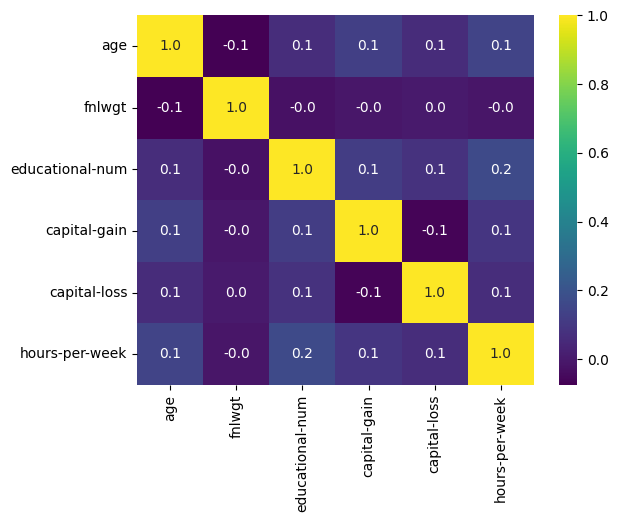

In [38]:
corr = X_train[num_cols].corr('spearman')

sns.heatmap(corr, annot=True, fmt='.1f', cmap='viridis')

### Categóricas

Vamos analisar a correlação usando um tipo de normalização do chi2 chamado v_cramer.

*conclusões:*

1. education e educational-num são equivalentes
2. existe grande correlação entre relationship, gender, marital status e occupation (acredito que muito em função das associações homem~marido e mulher~esposa)

Dado que gender possui considerável correlação entre genero e outras colunas, optou-se por manter as demais, pois elas já compreendem informação de gender e agregam outras.

Além disso, optou-se por remover a redundância de education

In [39]:
def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2 = chi2_contingency(table)[0]
    n = table.values.sum()
    r, c = table.shape
    return np.sqrt(chi2 / (n * (min(r, c) - 1)))

In [40]:
cramer_matrix = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramer_matrix.loc[col1, col2] = cramers_v(X_train[col1], X_train[col2])

<Axes: >

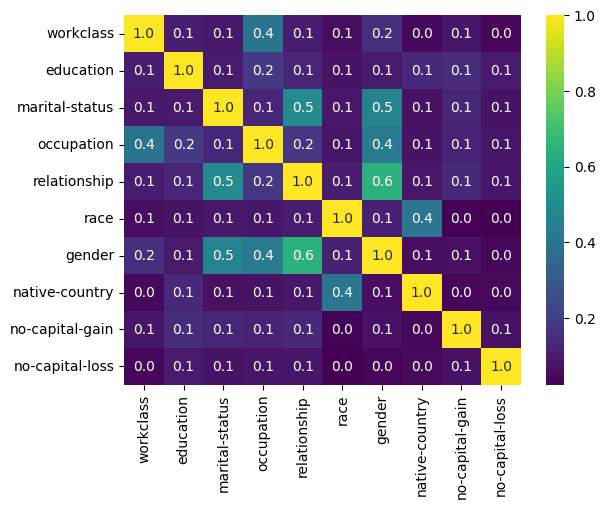

In [41]:
sns.heatmap(cramer_matrix, annot=True, fmt='.1f', cmap='viridis')

In [42]:
drop_cols = ['gender', 'education-num']

# 04. 🧪 Modelagem

## 04.a Naive Bayes

In [43]:
cat_cols = [col for col in cat_cols if not col in drop_cols]

In [45]:
num_pipe = Pipeline(steps=[
    ('bin', KBinsDiscretizer(n_bins=10, strategy='quantile', encode='ordinal')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

ct = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', num_pipe, num_cols)
    ],
    remainder='drop'
)

pipe = Pipeline(steps=[
    ('ct', ct),
    ('nb', BernoulliNB())
])

param_grid = {
    'nb__alpha': [1e-3, 1e-2, 1e-1, 0.5, 1, 2, 5, 10],
    'nb__fit_prior': [True, False],
    
}

nb = GridSearchCV(pipe, param_grid, cv=10, scoring='roc_auc')

nb.fit(X_train, y_train)

print(nb.best_score_)
print(nb.best_estimator_)
print(nb.best_params_)

0.8929522123521986
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'native-country',
                                                   'no-capital-gain',
                                                   'no-capital-loss']),
                                                 ('num',
                                                  Pipeline(steps=[('bin',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=10)),
                                   

## 04.b Logistic Regression

In [46]:
ct = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('ss', StandardScaler(), num_cols)
])

pipe = Pipeline(steps=[
    ('ct', ct),
    ('lreg', LogisticRegression())
])

param_grid = [
    {
        "lreg__solver": ["lbfgs"],
        "lreg__penalty": ["l2"],
        "lreg__C": [0.1, 1, 10]
    },
    {
        "lreg__solver": ["liblinear"],
        "lreg__penalty": ["l1", "l2"],
        "lreg__C": [0.1, 1, 10]
    },
    {
        "lreg__solver": ["saga"],
        "lreg__penalty": ["elasticnet"],
        "lreg__l1_ratio": [0.3, 0.5, 0.7],
        "lreg__C": [0.1, 1, 10]
    }
]

lreg = GridSearchCV(pipe, param_grid, cv=10, scoring='roc_auc')

lreg.fit(X_train, y_train)

print(lreg.best_score_)
print(lreg.best_estimator_)
print(lreg.best_params_)

0.9083690532873521
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'native-country',
                                                   'no-capital-gain',
                                                   'no-capital-loss']),
                                                 ('ss', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('lreg',
          

## 04.c CatBoost

In [47]:
num_pipe = Pipeline(steps=[
    ('bin', KBinsDiscretizer(n_bins=10, strategy='quantile', encode='ordinal')),
    ('num_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

ct = ColumnTransformer(transformers=[
    ('cat_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num_pipe', num_pipe, num_cols)
])

pipe = Pipeline(steps=[
    ('ct', ct),
    ('cb', CatBoostClassifier())
])

param_grid = {
    'cb__logging_level': ['Silent']
    # 'cb__learning_rate': [.01, .05, .1],
    # 'cb__iterations': [100, 200, 500, 1000],
    # 'cb__loss_function': ['logloss'],
    # 'cb__metric': ['AUC'],
    # 'cb __bootstrap_type': ['Bayesian']
}

cb = GridSearchCV(pipe, param_grid, cv=10, scoring='roc_auc')

cb.fit(X_train, y_train)

print(cb.best_score_)
print(cb.best_params_)
print(cb.best_estimator_)

0.902598832313514
{'cb__logging_level': 'Silent'}
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'native-country',
                                                   'no-capital-gain',
                                                   'no-capital-loss']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('bin',
                                                                   KBinsDiscretizer(encode='ordinal',
              

# 05. 🎯 Avaliação do Modelo Escolhido

*Escolhido:* Regressão Logística
*Motivos:" cirtério objetivo é a maior taxa de acerto dentro da medida escolhida. Porém, a diferença é pouco significativa, logo o critério para cravar a decisão foi a intepretabilidade do modelo.

In [48]:
X_test['no-capital-gain'] = X_test['capital-gain'].apply(lambda x: 1 if x == 0 else 0)
X_test['no-capital-gain'] = X_test['no-capital-gain'].astype('object')

X_test['no-capital-loss'] = X_test['capital-loss'].apply(lambda x: 1 if x == 0 else 0)
X_test['no-capital-loss'] = X_test['no-capital-loss'].astype('object')

In [49]:
y_score_nb = nb.predict_proba(X_test)[:, 1]
y_score_lreg = lreg.predict_proba(X_test)[:, 1]
y_score_cb = cb.predict_proba(X_test)[:, 1]

In [50]:
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_score_nb)
fpr_lreg, tpr_lreg, _ = roc_curve(y_test, y_score_lreg)
fpr_cb, tpr_cb, _ = roc_curve(y_test, y_score_cb)

auc1 = auc(fpr_nb, tpr_nb)
auc2 = auc(fpr_lreg, tpr_lreg)
auc3 = auc(fpr_cb, tpr_cb)

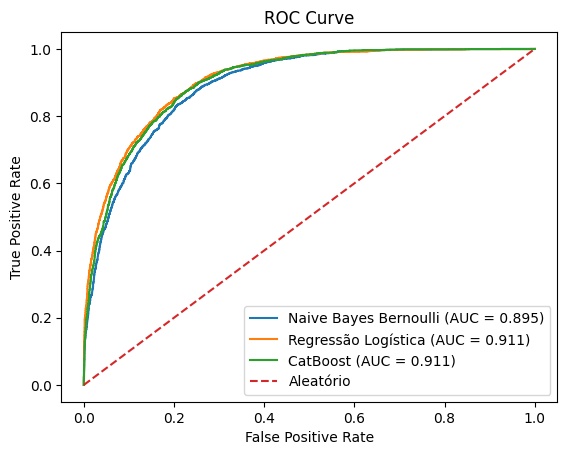

In [51]:
plt.figure()
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes Bernoulli (AUC = {auc1:.3f})')
plt.plot(fpr_lreg, tpr_lreg, label=f'Regressão Logística (AUC = {auc2:.3f})')
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc2:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Aleatório')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [52]:
y_pred = lreg.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7431
           1       0.75      0.60      0.67      2338

    accuracy                           0.86      9769
   macro avg       0.82      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769



In [53]:
coefs = lreg.best_estimator_.named_steps['lreg'].coef_[0]


In [54]:
features_names = lreg.best_estimator_.named_steps['ct'].get_feature_names_out()

In [55]:
coef_df = pd.DataFrame({
    'feature': features_names,
    'coef': coefs,
    'abs_coef': np.abs(coefs)
}).sort_values('abs_coef', ascending=False)

In [56]:
coef_df.head(20)

,feature,coef,abs_coef
98,ss__capital-gain,5.416482,5.416482
93,ohe__no-capital-gain_1,2.595700,2.595700
24,ohe__marital-status_Married-civ-spouse,2.493112,2.493112
23,ohe__marital-status_Married-AF-spouse,2.330001,2.330001
37,ohe__occupation_Priv-house-serv,-1.723474,1.723474
94,ohe__no-capital-loss_1,1.547776,1.547776
55,ohe__native-country_Columbia,-1.494899,1.494899
72,ohe__native-country_Ireland,1.258016,1.258016
92,ohe__native-country_Yugoslavia,1.097230,1.097230
0,ohe__workclass_Federal-gov,1.028991,1.028991


# 06. 💡 Conclusões

### Features que influênciam para ser a classe positiva (>50k):

1. capital_gain
2. O estado civil ser "Married-civ-spouse" ou "Married-AF-spouse"
3. não ter perda de capital registrada
4. ser dos países "Ireland", "Yugoslavia", "France"
5. ser da classe de trabalho "Federal-gov" (servidor público??)

*conclusão:* Parece que pessoas casadas e/ou imigrantes de países europeus e/ou servidores públicos tendem a ter uma renda superior (não necessariamente uma causalidade)

###  Features que influênciam para ser a classe negativa (<50k):

1. trabalhar com "Priv-house-serv" ou "Farming-fishing"
2. ser dos países "Columbia", "Laos", "Vietnam" ou "Mexico"
3. estado civil como "Other-relative"

*conclusão:* Aparentemente imigrantes da América Latina, Leste Asiático e/ou com trabalho rural e/ou estado civil como "outro" tendem a ter renda inferior (não necessariamente uma causalidade)

### Sugestão de próximo estudo e limitações

Aparentemente as features de ganho e perda de capital têm muita importância, pode fazer sentido conduzir um estudo sem levar elas em conta e averiguar o poder preditivo do modelo com as demais.